In [23]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as f
torch.set_float32_matmul_precision('medium')

In [24]:
class SharpenTransform:
    def __init__(self, sharpness_factor=2.0):
        self.sharpness_factor = sharpness_factor

    def __call__(self, img):
        return f.adjust_sharpness(img, self.sharpness_factor)

In [ ]:
class FERPlusDataset(Dataset):
    def __init__(self, img_folder, csv_file, transform=None, skip_nf=True):
        """
        Args:
            img_folder (str): Directory with all the images.
            csv_file (str): Path to the annotations CSV file.
            transform (callable, optional): Optional transforms to be applied on an image.
            skip_nf (bool): Whether to skip "NF" (Not Face) images during loading.
        """
        self.img_folder = img_folder
        self.transform = transform
        
        # Load CSV containing annotations and label distributions
        self.data = pd.read_csv(csv_file)

        # Filter rows based on dataset usage split in 'Usage' column, matching folder
        usage_map = {
            "FER2013Train": "Training",
            "FER2013Valid": "PublicTest",
            "FER2013Test": "PrivateTest"
        }
        usage_required = usage_map[os.path.basename(img_folder)]
        self.data = self.data[self.data['Usage'] == usage_required].reset_index(drop=True)

        # Optionally filter out NF records
        if skip_nf:
            self.data = self.data[self.data['NF'] == 0].reset_index(drop=True)

        # Define the emotion categories including "unknown" (order must match CSV columns)
        self.emotions = ['neutral','happiness','surprise','sadness','anger','disgust','fear','contempt','unknown']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.data.loc[idx, 'Image name']

        # Load image in grayscale mode
        img_path = os.path.join(self.img_folder, img_name)
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.Compose([
                transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
                SharpenTransform(sharpness_factor=5)
            ])(image)
        
        # Extract counts for emotions (including unknown)
        counts = self.data.loc[idx, self.emotions].values.astype(float)

        # Normalize counts to probabilities for label distribution
        label_distribution = counts / counts.sum()

        # Convert to tensor
        label_distribution = torch.tensor(label_distribution, dtype=torch.float32)

        return image, label_distribution

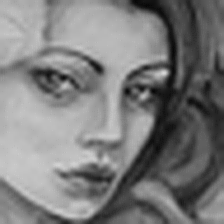

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [90]:
from IPython.display import display
train_imgs_path = "../FERPlusData/FER2013Train"
data_csv_path = "../fer2013new.csv"
val_imgs_path = "../FERPlusData/FER2013Valid"

val_dataset = FERPlusDataset(
    img_folder=val_imgs_path,
    csv_file=data_csv_path,
    skip_nf=True,
)
image, dist = val_dataset[7]
display(image)
print(dist)

In [26]:
train_imgs_path = "../FERPlusData/FER2013Train"
val_imgs_path = "../FERPlusData/FER2013Valid"
test_imgs_path = "../FERPlusData/FER2013Test"
data_csv_path = "../fer2013new.csv"

train_dataset = FERPlusDataset(
    img_folder=train_imgs_path,
    csv_file=data_csv_path,
    skip_nf=True,
    transform=transforms.Compose([
        transforms.Resize((112,112), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        SharpenTransform(sharpness_factor=2.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5076], std=[0.2119])
    ])
)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)
val_dataset = FERPlusDataset(
    img_folder=val_imgs_path,
    csv_file=data_csv_path,
    skip_nf=True,
    transform=transforms.Compose([
        transforms.Resize((112,112), interpolation=transforms.InterpolationMode.LANCZOS),
        SharpenTransform(sharpness_factor=2.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5076], std=[0.2119])
    ])
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)

In [27]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        scale = torch.sigmoid(out)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        scale = torch.sigmoid(self.conv(concat))
        return x * scale

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
            
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

In [29]:
class TwoBranchFERCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(TwoBranchFERCNN, self).__init__()

        # CBAM attention modules for each branch output (64 channels each)
        self.cbam1 = CBAM(64)
        self.cbam2 = CBAM(64)

        # Transformer encoder to fuse concatenated features
        # Embedding dimension = 128 (64+64), 2 attention heads, dropout 0.25
        # batch_first=True allows input shapes: [batch, seq_len, embed_dim]
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=4, dim_feedforward=512, dropout=0.25, batch_first=True),
            num_layers=1
        )

        # Branch 1: Two convolutional blocks (3x3 kernels) for fine detail extraction
        self.branch1 = nn.Sequential(
            ResBlock(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),

            ResBlock(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2)
        )

        # Branch 2: Two convolutional blocks (6x6 kernels) for broader detail extraction
        self.branch2 = nn.Sequential(
            ResBlock(1, 32, kernel_size=7, padding=3),
            nn.MaxPool2d(2),

            ResBlock(32, 64, kernel_size=7, padding=3),
            nn.MaxPool2d(2)
        )

        # Learnable scalar weights to balance branch outputs, initialized equally
        self.weight1 = nn.Parameter(torch.tensor(0.5))
        self.weight2 = nn.Parameter(torch.tensor(0.5))

        # Fully connected layer after transformer pooling; input features = 128 from transformer embedding size
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pass input through each branch and apply CBAM attention
        out1 = self.cbam1(self.branch1(x))  # Shape: [batch, 64, 12, 12]
        out2 = self.cbam2(self.branch2(x))  # Shape: [batch, 64, 12, 12]

        # Scale branch outputs by learnable weights
        out1 = out1 * self.weight1
        out2 = out2 * self.weight2

        # Ensure spatial sizes match via interpolation if needed before concatenation
        if out1.shape[2:] != out2.shape[2:]:
            out2 = F.interpolate(out2, size=out1.shape[2:], mode='bilinear', align_corners=False)

        # Concatenate feature maps along channel dimension -> [batch, 128, 12, 12]
        out = torch.cat((out1, out2), dim=1)

        # Prepare the tensor for transformer: flatten spatial dimensions and permute to [batch, seq_len, embed_dim]
        B, C, H, W = out.shape
        out = out.permute(0, 2, 3, 1).reshape(B, H * W, C)  # [batch, 144, 128]

        # Apply transformer encoder to model global context
        out = self.transformer(out)  # [batch, seq_len, embed_dim]

        # Global average pooling over the sequence length dimension to get fixed-size vector
        out = out.mean(dim=1)  # [batch, embed_dim]

        # Final classification layer
        logits = self.fc(out)  # [batch, num_classes]
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoBranchFERCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

def loss_fn(logits, label_distributions):
    log_probs = F.log_softmax(logits, dim=1)
    loss = F.kl_div(log_probs, label_distributions, reduction='batchmean')
    return loss

In [31]:
from torchmetrics import Accuracy, MeanSquaredError
from tqdm import tqdm

def training_val_loop_amp(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs, device):
    # Initialize metrics
    train_acc = Accuracy(task='multiclass', num_classes=9).to(device)
    val_acc = Accuracy(task='multiclass', num_classes=9).to(device)
    train_mse = MeanSquaredError().to(device)
    val_mse = MeanSquaredError().to(device)

    # Initialize GradScaler for AMP
    scaler = torch.amp.GradScaler()

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0
        train_acc.reset()
        train_mse.reset()

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with automatic mixed precision
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = loss_fn(outputs, labels)

            # Backpropagation scaled for AMP
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            targets = torch.argmax(labels, dim=1)
            train_acc.update(preds, targets)
            train_mse.update(F.softmax(outputs, dim=1), labels)

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc.compute().item()
        avg_train_mse = train_mse.compute().item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_acc.reset()
        val_mse.reset()

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False)
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                for images, labels in val_bar:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    total_val_loss += loss.item() * images.size(0)

                    preds = torch.argmax(outputs, dim=1)
                    targets = torch.argmax(labels, dim=1)
                    val_acc.update(preds, targets)
                    val_mse.update(F.softmax(outputs, dim=1), labels)

                    val_bar.set_postfix(loss=loss.item())

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        avg_val_acc = val_acc.compute().item()
        avg_val_mse = val_mse.compute().item()

        scheduler.step()

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Train MSE: {avg_train_mse:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, Val MSE: {avg_val_mse:.4f}")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)

num_epochs = 30

training_val_loop_amp(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=num_epochs,
    device=device
)

Epoch 1 Training:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 1.0611, Train Acc: 0.4321, Train MSE: 0.0438 | Val Loss: 0.9589, Val Acc: 0.5562, Val MSE: 0.0394


Epoch 2/30 | Train Loss: 0.7538, Train Acc: 0.6162, Train MSE: 0.0292 | Val Loss: 0.7523, Val Acc: 0.6248, Val MSE: 0.0302


Epoch 3/30 | Train Loss: 0.6462, Train Acc: 0.6643, Train MSE: 0.0245 | Val Loss: 0.6583, Val Acc: 0.6666, Val MSE: 0.0261


Epoch 4/30 | Train Loss: 0.5877, Train Acc: 0.6941, Train MSE: 0.0218 | Val Loss: 0.6088, Val Acc: 0.6881, Val MSE: 0.0232


Epoch 5/30 | Train Loss: 0.5533, Train Acc: 0.7082, Train MSE: 0.0202 | Val Loss: 0.5617, Val Acc: 0.7069, Val MSE: 0.0212


Epoch 6/30 | Train Loss: 0.5256, Train Acc: 0.7197, Train MSE: 0.0190 | Val Loss: 0.5169, Val Acc: 0.7377, Val MSE: 0.0194


Epoch 7/30 | Train Loss: 0.5050, Train Acc: 0.7305, Train MSE: 0.0180 | Val Loss: 0.5639, Val Acc: 0.7235, Val MSE: 0.0211


Epoch 8/30 | Train Loss: 0.4855, Train Acc: 0.7418, Train MSE: 0.0172 | Val Loss: 0.4941, Val Acc: 0.7403, Val MSE: 0.0183


Epoch 9/30 | Train Loss: 0.4688, Train Acc: 0.7504, Train MSE: 0.0164 | Val Loss: 0.4944, Val Acc: 0.7417, Val MSE: 0.0182


Epoch 10/30 | Train Loss: 0.4539, Train Acc: 0.7589, Train MSE: 0.0157 | Val Loss: 0.5077, Val Acc: 0.7344, Val MSE: 0.0189


Epoch 11/30 | Train Loss: 0.4409, Train Acc: 0.7645, Train MSE: 0.0152 | Val Loss: 0.5191, Val Acc: 0.7428, Val MSE: 0.0190


Epoch 12/30 | Train Loss: 0.4315, Train Acc: 0.7697, Train MSE: 0.0146 | Val Loss: 0.4587, Val Acc: 0.7660, Val MSE: 0.0165


Epoch 13/30 | Train Loss: 0.4181, Train Acc: 0.7763, Train MSE: 0.0140 | Val Loss: 0.4416, Val Acc: 0.7747, Val MSE: 0.0157


Epoch 14/30 | Train Loss: 0.4101, Train Acc: 0.7807, Train MSE: 0.0137 | Val Loss: 0.4448, Val Acc: 0.7778, Val MSE: 0.0156


Epoch 15/30 | Train Loss: 0.4008, Train Acc: 0.7849, Train MSE: 0.0133 | Val Loss: 0.4480, Val Acc: 0.7694, Val MSE: 0.0160


Epoch 16/30 | Train Loss: 0.3886, Train Acc: 0.7908, Train MSE: 0.0127 | Val Loss: 0.4426, Val Acc: 0.7638, Val MSE: 0.0162


Epoch 17/30 | Train Loss: 0.3789, Train Acc: 0.7950, Train MSE: 0.0122 | Val Loss: 0.4417, Val Acc: 0.7786, Val MSE: 0.0153


Epoch 18/30 | Train Loss: 0.3722, Train Acc: 0.8011, Train MSE: 0.0119 | Val Loss: 0.4291, Val Acc: 0.7792, Val MSE: 0.0151


Epoch 19/30 | Train Loss: 0.3662, Train Acc: 0.8040, Train MSE: 0.0117 | Val Loss: 0.4380, Val Acc: 0.7725, Val MSE: 0.0156


Epoch 20/30 | Train Loss: 0.3576, Train Acc: 0.8054, Train MSE: 0.0113 | Val Loss: 0.4157, Val Acc: 0.7896, Val MSE: 0.0143


Epoch 21/30 | Train Loss: 0.3512, Train Acc: 0.8139, Train MSE: 0.0110 | Val Loss: 0.4139, Val Acc: 0.7924, Val MSE: 0.0142


Epoch 22/30 | Train Loss: 0.3454, Train Acc: 0.8134, Train MSE: 0.0107 | Val Loss: 0.4250, Val Acc: 0.7843, Val MSE: 0.0149


Epoch 23/30 | Train Loss: 0.3398, Train Acc: 0.8189, Train MSE: 0.0104 | Val Loss: 0.4131, Val Acc: 0.7991, Val MSE: 0.0140


Epoch 24/30 | Train Loss: 0.3332, Train Acc: 0.8231, Train MSE: 0.0101 | Val Loss: 0.4073, Val Acc: 0.7980, Val MSE: 0.0139


Epoch 25/30 | Train Loss: 0.3282, Train Acc: 0.8227, Train MSE: 0.0099 | Val Loss: 0.4111, Val Acc: 0.7977, Val MSE: 0.0139


Epoch 26/30 | Train Loss: 0.3266, Train Acc: 0.8248, Train MSE: 0.0098 | Val Loss: 0.4066, Val Acc: 0.7985, Val MSE: 0.0138


Epoch 27/30 | Train Loss: 0.3229, Train Acc: 0.8287, Train MSE: 0.0097 | Val Loss: 0.4076, Val Acc: 0.7983, Val MSE: 0.0139


Epoch 28/30 | Train Loss: 0.3188, Train Acc: 0.8305, Train MSE: 0.0094 | Val Loss: 0.4078, Val Acc: 0.7955, Val MSE: 0.0139


Epoch 29/30 | Train Loss: 0.3187, Train Acc: 0.8305, Train MSE: 0.0094 | Val Loss: 0.4069, Val Acc: 0.7985, Val MSE: 0.0138


Epoch 30/30 | Train Loss: 0.3168, Train Acc: 0.8326, Train MSE: 0.0094 | Val Loss: 0.4054, Val Acc: 0.7971, Val MSE: 0.0137
